# Yeast CarbonSources, MaxQuant


## Introduction

This is analysis of a public dataset (PRIDE [PXD002875](https://www.ebi.ac.uk/pride/archive/projects/PXD002875)) from Paulo, O'Connell, Gaun, and Gygi:

> Paulo, J.A., O’Connell, J.D., Gaun, A. and Gygi, S.P., 2015. Proteome-wide quantitative multiplexed profiling of protein expression: carbon-source dependency in Saccharomyces cerevisiae. Molecular biology of the cell, 26(22), pp.4063-4074.

There were 24 RAW files of yeast grown in three different carbon sources. It was a 3x3 (9-plex) TMT experiment done with the SPS MS3 (MultiNotch) method (**ref-1**).

Here are some ballpark numbers from the published paper. There were about 4700 quantifiable proteins at a low FDR. The 3 by 3 study design was tested for differential expression significance using a one-way ANOVA test with a Bonferroni multiple testing correction. 1003 proteins were found to be significant at a corrected p-value cutoff of 0.01.

An analysis using the [PAW pipeline](https://github.com/pwilmart/PAW_pipeline.git) was also done (repo [here](https://github.com/pwilmart/Yeast_CarbonSources.git) or notebook HTML file [here](https://pwilmart.github.io/TMT_analysis_examples/CarbonSources_part-1.html)). 


## Processing

The RAW files were downloaded and reprocessed with MaxQuant (**ref-2**) 1.6.3.3. SPS MS3 data type was selected and 10-plex TMT reagents used. The protein database (without contaminants or decoys) was the same as used for the PAW analysis. Most parameters were kept as defaults (parameter file is included). 

> **References**

> **1.**  McAlister, G.C., Nusinow, D.P., Jedrychowski, M.P., Wühr, M., Huttlin, E.L., Erickson, B.K., Rad, R., Haas, W. and Gygi, S.P., 2014. MultiNotch MS3 enables accurate, sensitive, and multiplexed detection of differential expression across cancer cell line proteomes. Analytical chemistry, 86(14), pp.7150-7158.

> **2.** Cox, J. and Mann, M., 2008. MaxQuant enables high peptide identification rates, individualized ppb-range mass accuracies and proteome-wide protein quantification. Nature biotechnology, 26(12), p.1367.


## Load in MaxQuant data

MaxQuant (MQ) summarizes (sums) reporter ions into protein totals using the specified protein inference and shared peptide settings. I used the defaults of razor+unique. This is an area where MQ and PAW differ. MQ also applies a protein ranking function for protein FDR and usually reports single peptide per protein identifications. I kept the default setting of 1% PSM, 1% protein, and a minimum of one peptide per protein. 

Before we do any visualizations and work with the data in edgeR, we need to do a little data prep. Any contaminant proteins (common contaminants like keratins, trypsin, and BSA, and any biological contaminants (proteins from adjacent tissue, blood, etc.) should be removed from the table. Any decoy identifications should also be dropped. There can also be proteins that do not have any reporter ion intensities (quantification is typically stricter than identification) that can be dropped from the table. 

MQ output tables are extensive, so a streamlined table with just the information for the TMT data was exported from the proteinGroups.txt file using Excel. My approach is to open the main results file and do some data filtering and table reorganization using Excel's interactivity. I find it easier to so some data checking in Excel compared to R (I have been using Excel longer). The sheet has a "Log" tab with step by step descriptions of the data prep. I do not worry about the potential non-reproducibility of this because the Excel spreadsheet will be my main results summary file. I want the results for the R analysis to get added back to the spreadsheet so that everything is in one place for publication. Preparing the sheet layout to facilitate the data export also prepares the sheet to receive the edgeR results. These steps can also be done in R (if you are careful). The cleaned-up reporter ion data is what we will import here.

### Normalization steps for TMT experiments

Reporter ions within a single TMT plex should be normalized to a common level. The same total amount of protein digest is labeled for each channel so the total reporter ion signal for each channel should also be the same total amount (the reporter ion signals are proxies for protein abundances). We will do a grand total of reporter ion intensities normalization first to see if any channels have issues. We should have normalization factors within a factor of two (or less) of the average grand total. 

In [1]:
# load libraries first
library("psych")
library("tidyverse")
library("stringr")
library("gridExtra")
library("scales")
library("edgeR")
library("limma")

Warning message:
“package ‘psych’ was built under R version 3.5.2”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
Warning message:
“package ‘tibble’ was built under R version 3.5.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()   masks psych::%+%()
✖ ggplot2::alpha() masks psych::alpha()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

The following objects are masked from ‘package:psych’:

    alpha, rescale

Warning message:
“package ‘edgeR’ was built under R version 3

In [2]:
# load the data file into a data tibble 
raw_data <- read_tsv(file = "R-input.txt")

# separate row identifiers from the data
accession <- raw_data$Accession
tmt_raw <- raw_data %>% select(-c(Accession))

# let's use more descriptive column names
colnames(tmt_raw) <- c("gal-1", "gal-2", "gal-3", 
                        "glu-1", "glu-2", "glu-3",
                        "raf-1", "raf-2", "raf-3")
nrow(tmt_raw)

Parsed with column specification:
cols(
  Accession = col_character(),
  `126C` = col_double(),
  `127-N` = col_double(),
  `127C` = col_double(),
  `128-N` = col_double(),
  `128C` = col_double(),
  `129-N` = col_double(),
  `129C` = col_double(),
  `130-N` = col_double(),
  `130C` = col_double()
)


[1] 4728

### See what data is like before any normalization

We have the first 3 channels (in mass order) from galactose, the next 3 from glucose, and the last three from raffinose.

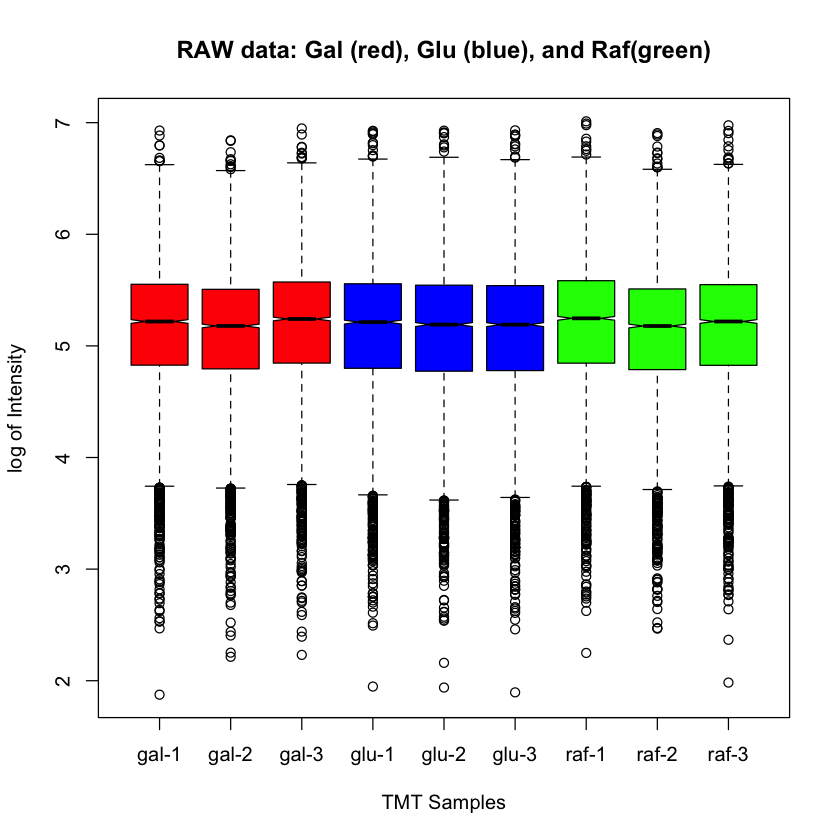

In [3]:
# let's see what the starting data look like
# set a 3 by 3 color vector
color_vector <- rep(c("red", "blue", "green"), each = 3)

# boxplots of RAW log intensities
boxplot(log10(tmt_raw), col = color_vector, 
        notch = TRUE, main = "RAW data: Gal (red), Glu (blue), and Raf(green)",
        xlab = "TMT Samples", ylab = "log of Intensity")

## Sample Loading (SL) normalization

The boxplots above already look excellent and we have not done any normalizations. We can compute normalization factors to make each column of reporter ion intensities sum to the same value. We loaded equal amounts of labeled protein digests, so we should have equal sums of reporter ions (in a perfect world). Large correction factors might imply a problem with the labeling for that channel.

In [4]:
SL_Norm <- function(df) {
    # This makes each channel sum to the average grand total
        # df - data frame of TMT intensities
        # returns a new data frame with normalized values
    norm_facs <- mean(c(colSums(df))) / colSums(df)
    cat("SL Factors:\n", sprintf("%-5s -> %f\n", colnames(df), norm_facs))
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")
}

# normalize the raw data
tmt_sl <- SL_Norm(tmt_raw)

SL Factors:
 gal-1 -> 1.033256
 gal-2 -> 1.142456
 gal-3 -> 0.978918
 glu-1 -> 0.947142
 glu-2 -> 0.973935
 glu-3 -> 0.974978
 raf-1 -> 0.913202
 raf-2 -> 1.079512
 raf-3 -> 0.994318


### We can also visualize the SL normalized data

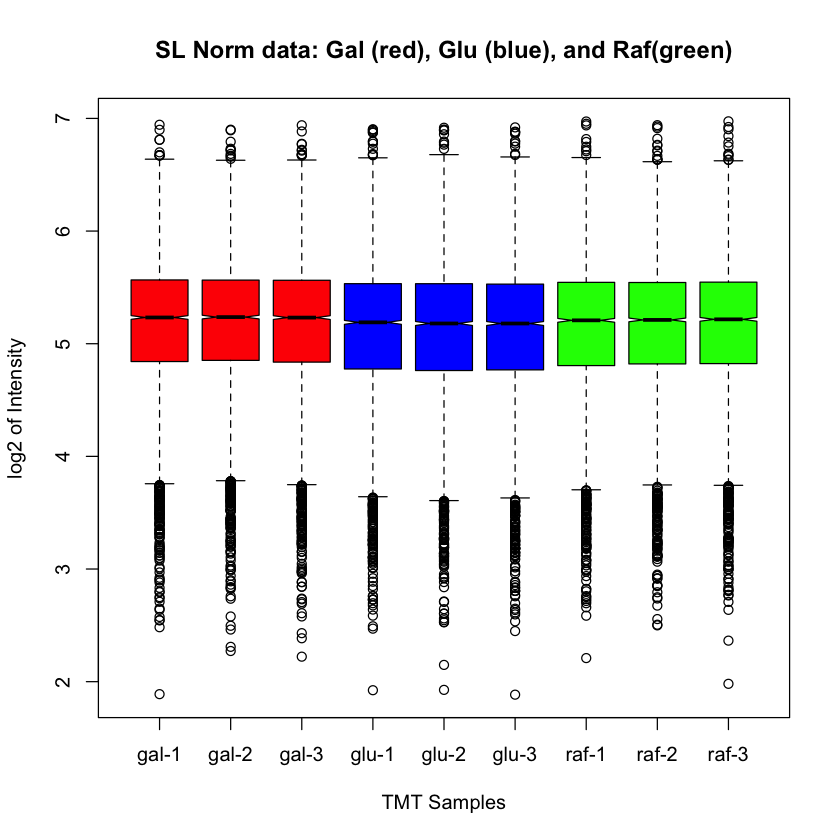

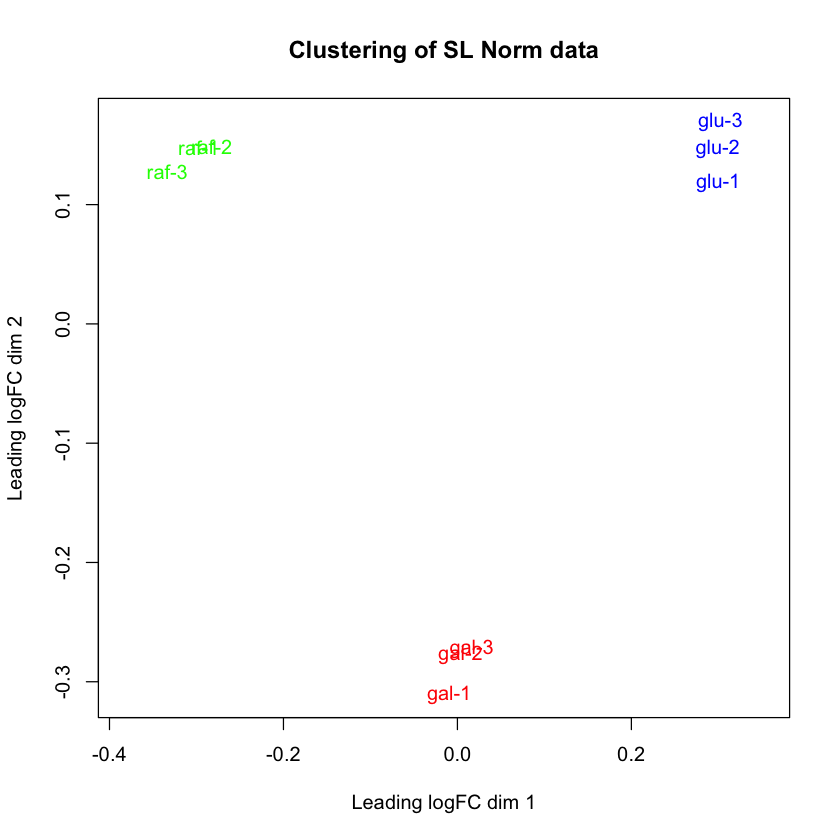

In [5]:
# let's see what the SL normalized data look like
boxplot(log10(tmt_sl), col = color_vector, 
        notch = TRUE, main = "SL Norm data: Gal (red), Glu (blue), and Raf(green)",
        xlab = "TMT Samples", ylab = "log2 of Intensity")

# and check clustering
plotMDS(log10(tmt_sl), col = color_vector, main = "Clustering of SL Norm data")

### Clustering looks great and SL correction factors were all close to 1

Boxplots are nicely aligned after the SL Norm step. All of the normalization factors were close to 1.0. The cluster plot shows tight grouping by condition and large separations between conditions. There should be some very clear differential expression candidates between conditions.

## Load edgeR data structures and normalize data using TMM

In [6]:
# load data, study design, and row labels into edgeR object
group <- rep(c("gal", "glu", "raf"), each = 3)
y <- DGEList(counts = tmt_raw, group = group, genes = accession)

# run TMM normalization
y <- calcNormFactors(y) 
y$samples

group lib.size   norm.factors
gal-1 gal   1407440511 1.0672384   
gal-2 gal   1272911948 1.0764609   
gal-3 gal   1485564781 1.0566643   
glu-1 glu   1535405101 0.9572438   
glu-2 glu   1493165086 0.9392793   
glu-3 glu   1491568283 0.9387737   
raf-1 raf   1592469268 0.9824748   
raf-2 raf   1347133101 0.9939443   
raf-3 raf   1462555818 0.9994050

### Check the TMM normalization results

TMM normalization factors were all very close to 1.0. We can get the norm factors from the DGEList object and create the normalized reporter ion intensities. EdgeR does not return adjusted intensities; the factors are used internally in the modeling. We can compute the adjusted values and save them. We can repeat the cluster and boxplot visualizations on the TMM normalized data.

In [7]:
apply_tmm_factors <- function(y) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(tmt_raw), "_tmm")
    
    # return the data frame
    tmt_tmm
}
tmt_tmm <- apply_tmm_factors(y)

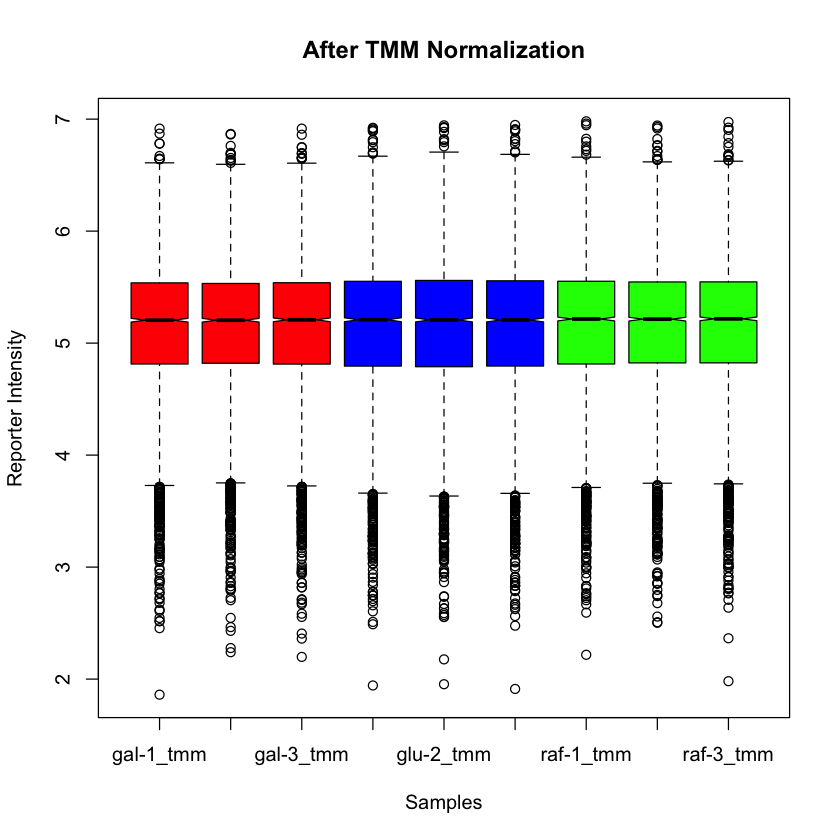

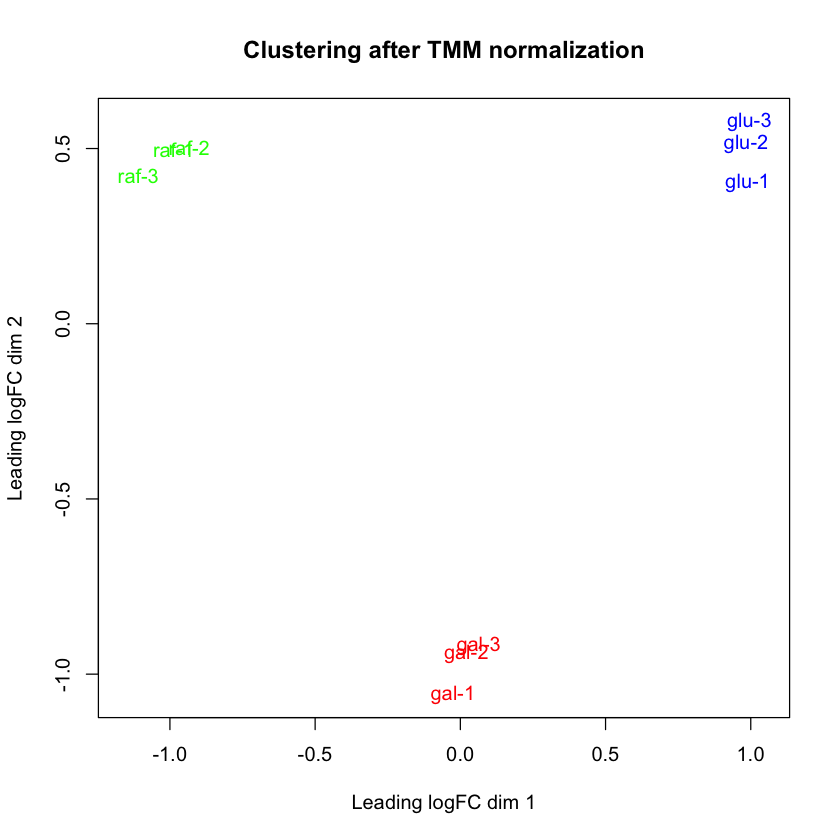

In [8]:
# look at intensity distributions across samples after TMM
boxplot(log10(tmt_tmm), 
        col = color_vector,
        xlab = "Samples", ylab = "Reporter Intensity", 
        main = "After TMM Normalization", notch = TRUE)

# check clustering after TMM with MDS plot
plotMDS(y, col = color_vector, main = "Clustering after TMM normalization")

### Hard to see if TMM did much...

Boxplots and clustering look pretty similar between SL Norm and TMM Norm. About all I can see is that the MDS plot axes ranges are a bit larger after TMM, indicating a little bigger difference between groups after TMM compared to SL norm.


## Sample-to-sample scatter plots are also useful

We can see how similar samples are to each other (within and between groups) using a multiple panel scatter plot visualization. The first three are the galactose carbon source, the next three are glucose, and the last three are raffinose.

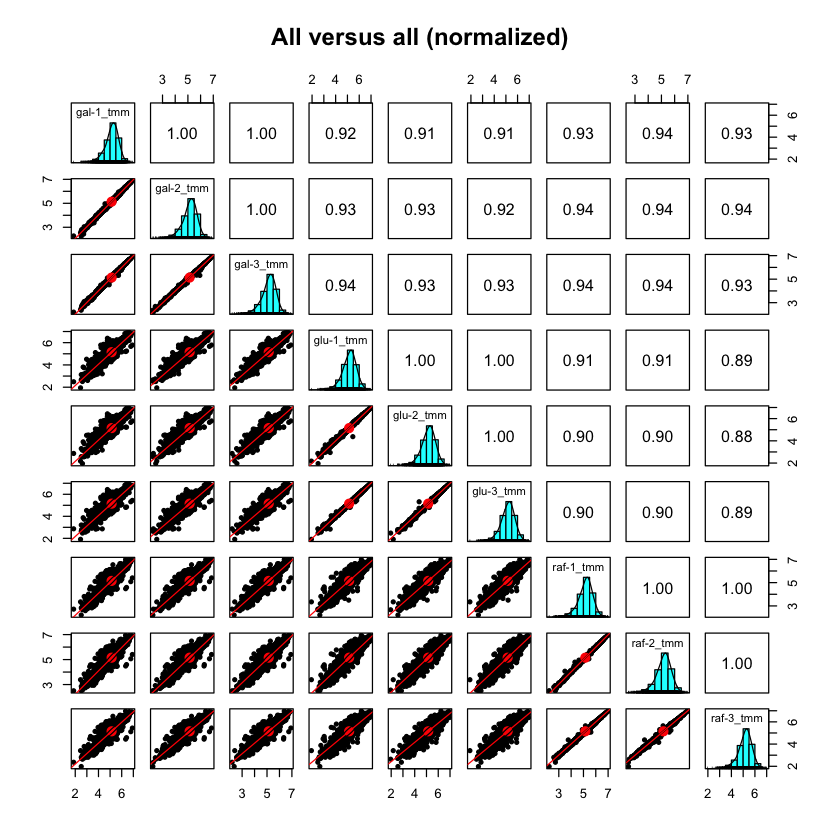

In [9]:
# compare all samples to each other
pairs.panels(log10(tmt_tmm), method = "spearman", 
             lm = TRUE, main = "All versus all (normalized)")

### Clustering and scatter plots indicate large differences between groups

The scatter plots indicate superb sample-to-sample reproducibility with the same condition (carbon source), and very significant differences between groups. The correlation coefficients within conditions are all 1.00 and coefficients between groups in the 0.92 to 0.96 range. Although the plots look quite different between conditions, the correlation coefficients are still very close to 1. Correlation coefficients are not a very sensitive metric. 

### Samples are in blocks of three

In [10]:
# save the indexes of each condition
gal <- 1:3
glu <- 4:6
raf <- 7:9

## CV distributions show how similar biological replicates are

We can use distributions of protein coefficients of variance (CV) to quantify how similar the samples within groups are. Using a little helper function, we can make boxplots of various sample groups. I will look at the CVs for each group before and after TMM normalization. The CVs are in percent.

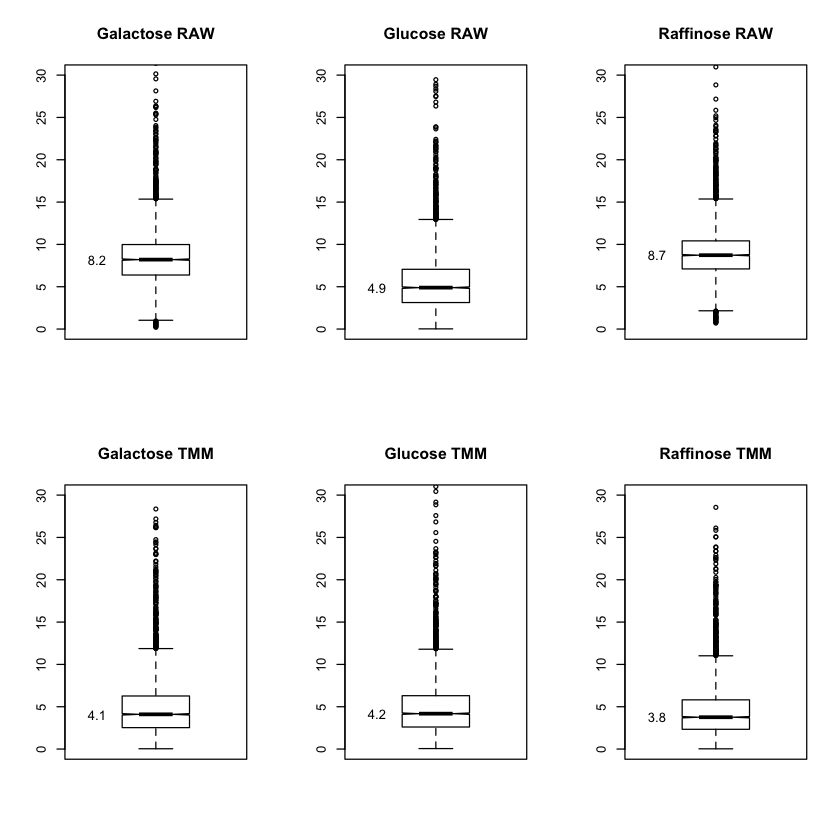

In [11]:
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

# make CV distributions for each condition before and after normalization
par(mfrow = c(2, 3))

labeled_boxplot(tmt_raw[gal], 30, "Galactose RAW")
labeled_boxplot(tmt_raw[glu], 30, "Glucose RAW")
labeled_boxplot(tmt_raw[raf], 30, "Raffinose RAW")
labeled_boxplot(tmt_tmm[gal], 30, "Galactose TMM")
labeled_boxplot(tmt_tmm[glu], 30, "Glucose TMM")
labeled_boxplot(tmt_tmm[raf], 30, "Raffinose TMM")

par(mfrow = c(1, 1))

### How "tight" are the CV distributions?

Median CVs were improved by TMM normalization for all three conditions. The sizes of the boxes (inter-quartile ranges) are also pretty small. It might be useful to see the full distributions.

Gal - 90% of CVs less than: 8.82 %
Glu - 90% of CVs less than: 9.07 %
Raf - 90% of CVs less than: 8.52 %


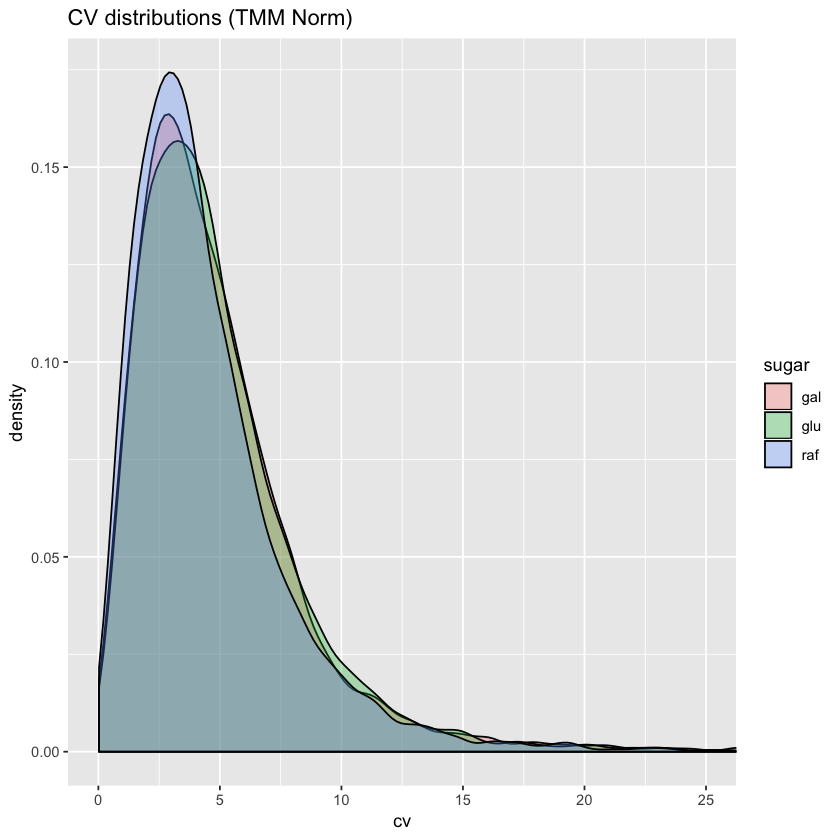

In [12]:
# print CV cutoffs that cature 90% of the proteins
cat("Gal - 90% of CVs less than:", round(quantile(CV(tmt_tmm[gal]), probs = 0.9), 2), "%\n")
cat("Glu - 90% of CVs less than:", round(quantile(CV(tmt_tmm[glu]), probs = 0.9), 2), "%\n")
cat("Raf - 90% of CVs less than:", round(quantile(CV(tmt_tmm[raf]), probs = 0.9), 2), "%\n")

# make a tidy data frame for plotting
cv_gal <- data.frame(cv = CV(tmt_tmm[gal]), sugar = "gal", stringsAsFactors = FALSE)
cv_glu <- data.frame(cv = CV(tmt_tmm[glu]), sugar = "glu", stringsAsFactors = FALSE)
cv_raf <- data.frame(cv = CV(tmt_tmm[raf]), sugar = "raf", stringsAsFactors = FALSE)
cv_long <- rbind(cv_gal, cv_glu, cv_raf)

# density plots
ggplot(cv_long, aes(x = cv, fill = sugar)) +
  geom_density(alpha = 0.3) +
  coord_cartesian(xlim = c(0, 25)) +
  ggtitle("CV distributions (TMM Norm)")

### 90% of the proteins have CVs less than about 9%

# Main statistical testing

We will do pairwise exact tests in edgeR. We have already loaded data into a DGEList object (above) and ran the TMM normalization. We need to get the global dispersion estimates before doing the pairwise exact statistical testing.

Design matrix not provided. Switch to the classic mode.


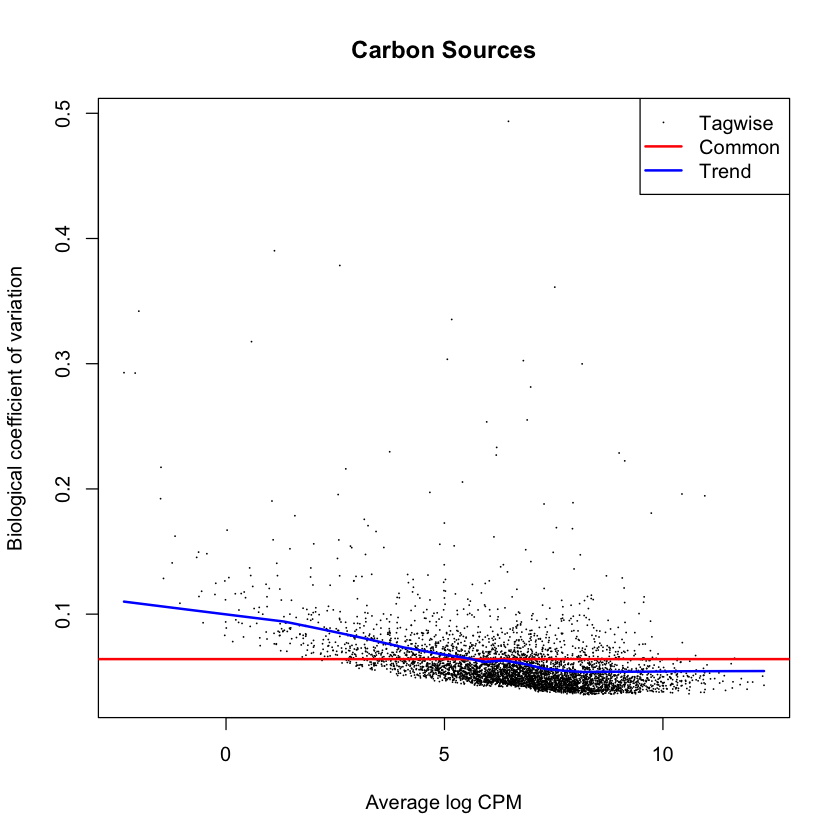

In [13]:
# compute the shared variance estimates and plot variance trends
y <- estimateDisp(y)
plotBCV(y, main = "Carbon Sources")

## Do the Galactose versus Glucose comparison first

We will save some average condition intensity vectors (for plotting purposes), compute the statistical models, save the results, and see what the top differential candidates are.

In [14]:
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate = cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                    labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

In [15]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("gal", "glu"))

# see which proteins have the smallest p-values
topTags(et)$table

# make the results table 
tt <- topTags(et, n = Inf, sort.by = "none")$table
gal_glu <- collect_results(tmt_tmm, tt, gal, "gal", glu, "glu")

genes                 logFC    logCPM   PValue        FDR          
4464 sp|Q12289|CRC1_YEAST  3.717883 7.453908  0.000000e+00  0.000000e+00
3335 sp|P80235|CACM_YEAST  3.066281 8.306803  0.000000e+00  0.000000e+00
2162 sp|P40017|YAT2_YEAST  2.789030 9.099938  0.000000e+00  0.000000e+00
1238 sp|P32907|ATO2_YEAST  3.290920 5.453545 9.881313e-322 1.167971e-318
1443 sp|P36035|JEN1_YEAST  2.344945 8.195043 1.152263e-312 1.089580e-309
2108 sp|P39932|STL1_YEAST  3.535829 4.037952 2.945981e-303 2.321433e-300
2481 sp|P41939|IDHC_YEAST  3.147042 8.070887 4.760606e-297 3.215449e-294
261  sp|P08679|CISY2_YEAST 3.008651 9.094337 2.651631e-291 1.567114e-288
4545 sp|Q12428|PRPD_YEAST  1.794221 8.534041 1.554018e-281 8.163777e-279
1187 sp|P32796|CACP_YEAST  3.194183 8.715620 4.906182e-265 2.319643e-262

### Is the test appropriate for this data?

The p-value distribution is way to check that the data and the statistical test are compatible (not necessarily correct). We should have a flat distribution from non-differentially expressed candidates at larger p-values and an increase at small p-values from true candidates.

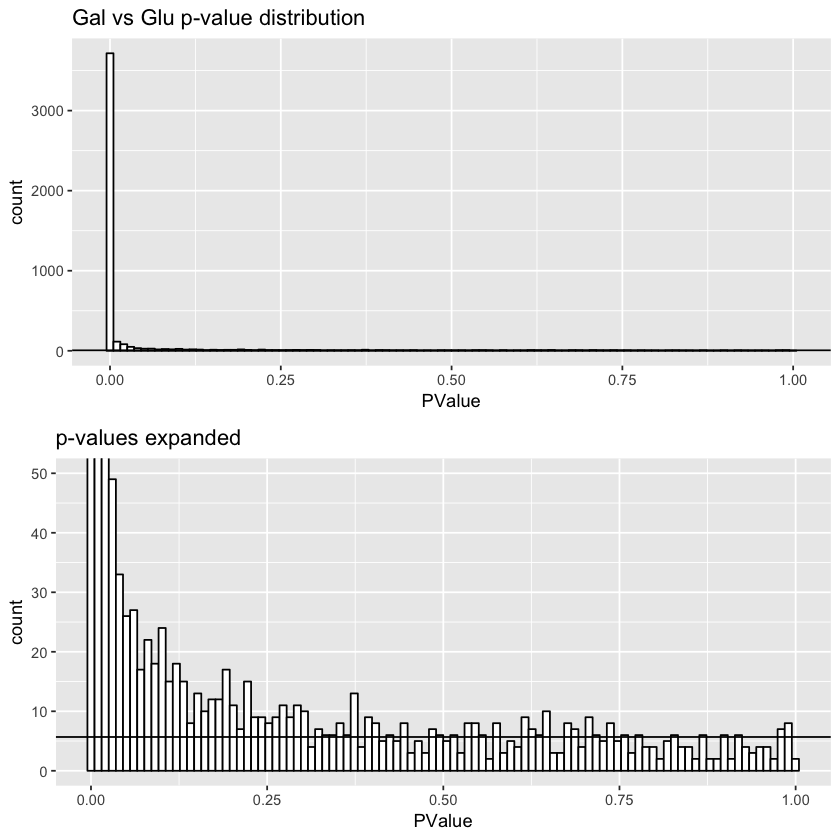

In [16]:
pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, 50)) + ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# check the p-value distribution
pvalue_plots(gal_glu, 50, "Gal vs Glu")

### P-value distribution looks good

The peak at small p-values from true differential expression candidates is dominant. We sort of have a flat distribution of larger p-values, but we had to expand the scale to see them.

### See how many DE candidates and visualize them

edgeR has some built-in functions for some quick checks of the statistical testing. We can get the number of up and down regulated proteins and make an MA plot of candidates. Up is over-expression in second condition (glu), down is over-expression in first condition (gal).

       glu-gal
Down      2042
NotSig     642
Up        2044

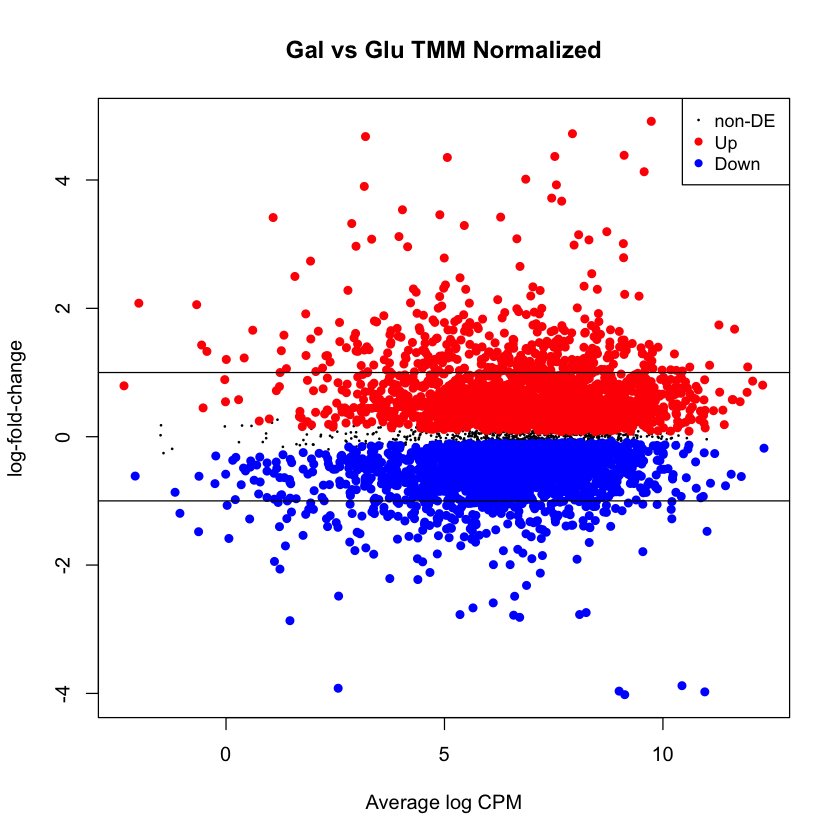

In [17]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))

# use function from limma for MD plot
plotMD(et, main = "Gal vs Glu TMM Normalized", p.value = 0.10)
abline(h = c(-1, 1), col = "black")

### We can also make some other plots

ggplot2 can make some nicer looking plots with modern colors and design elements, and gives us some options for exploring categories (color and symbols by category, and multi-panel facet plots).

candidate n   
1 high      3763
2 med        221
3 low        102
4 no         642

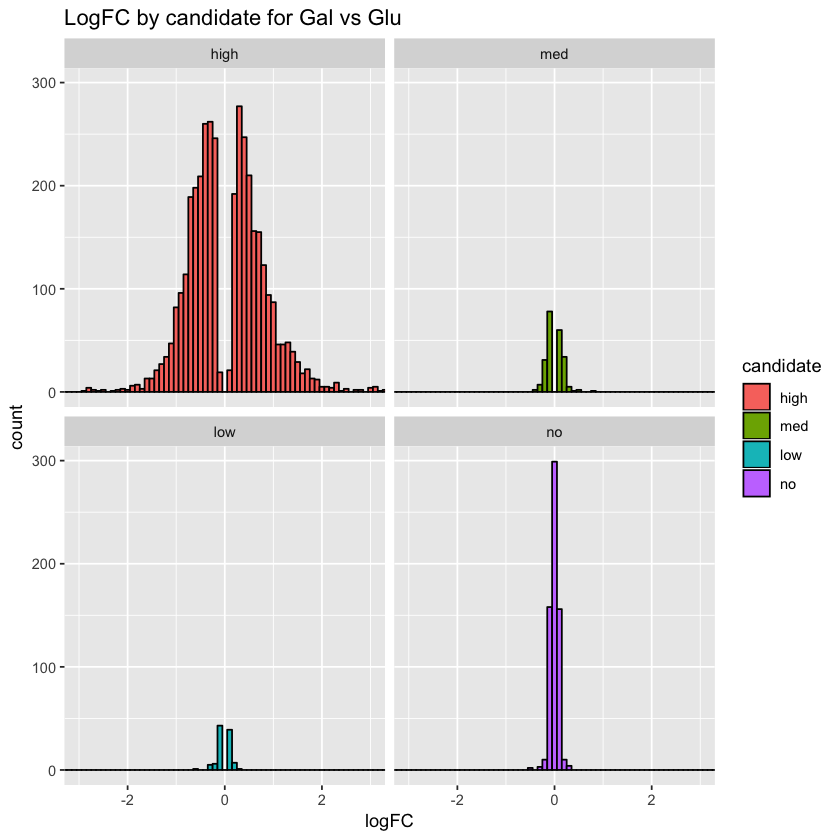

In [18]:
# see how many candidates are in each category
gal_glu %>% count(candidate)

log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# can also look at log2FC distributions
log2FC_plots(gal_glu, 3, "LogFC by candidate for Gal vs Glu")

### Up and down expression is pretty balanced

From the edgeR summaries and MA plot, there is good balance between up and down regulation. We also see that in the logFC plots above.

### Make a plotting function (we will need to call this 3 times)

In [19]:
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

### Galactose versus Glucose MA plots

MA plots are commonly used in genomics studies to show expression levels and highlight DE candidates.

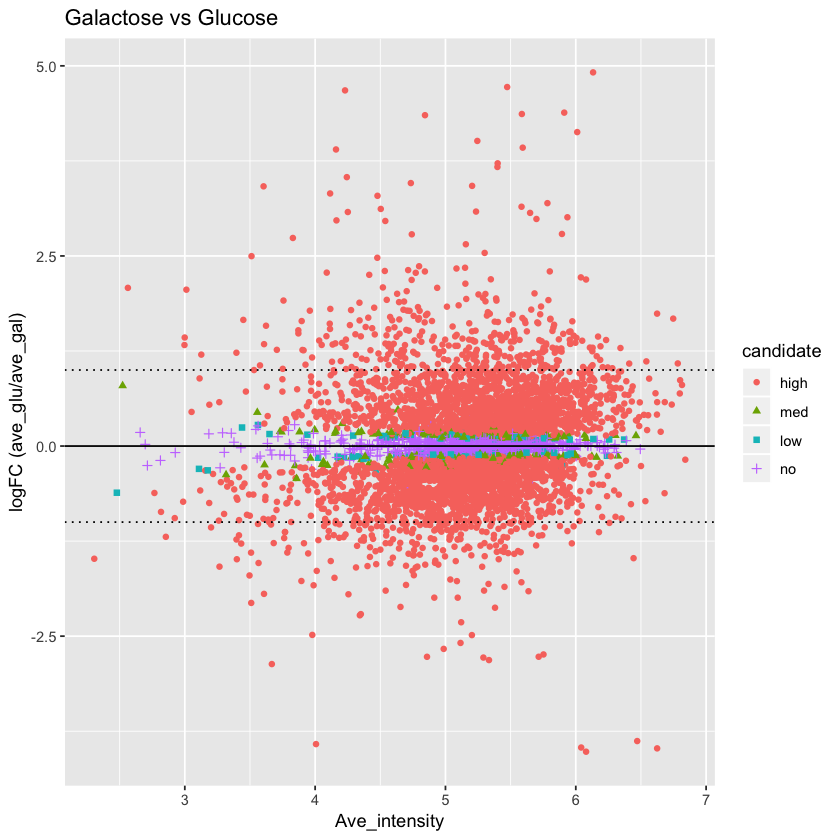

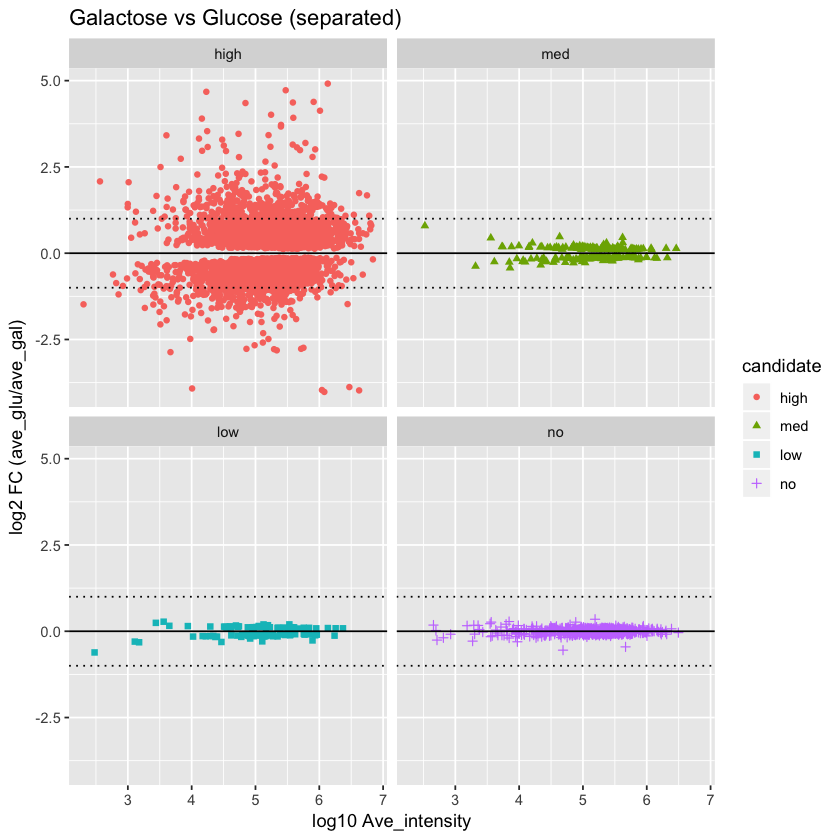

In [20]:
# do the gal vs glu MA visualizations
MA_plots(gal_glu, "ave_gal", "ave_glu", "Galactose vs Glucose")

### Same data visualized with scatter plots

Scatter plots and MA plots are very closely related. One thing I like about scatter plots is that both axes are in natural scales. Both axes are transformations of intensities for MA plots. The y-axis in MA plots will usually be auto scaled so that datasets with low or high variability often look similar. The scatter plots display dispersion in a more absolute way.

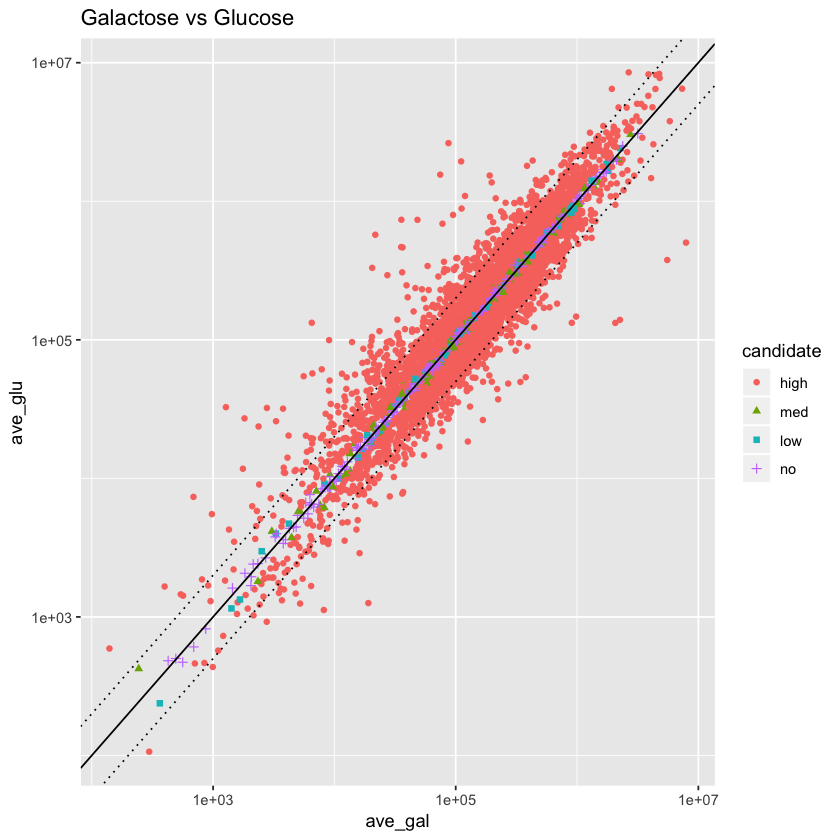

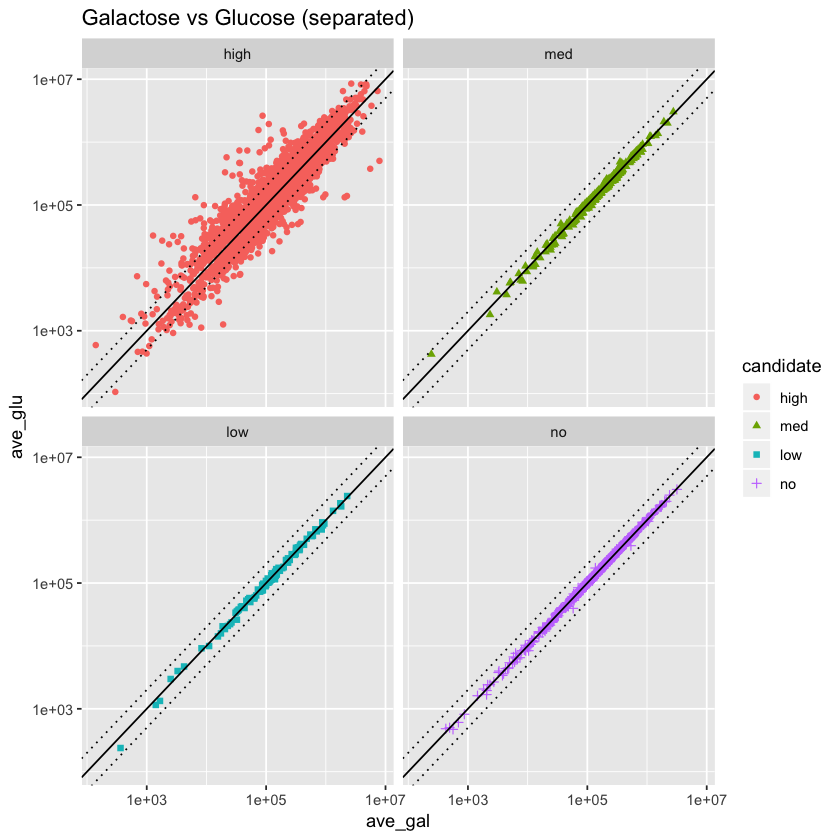

In [21]:
# same comparison with scatter plots
scatter_plots(gal_glu, "ave_gal", "ave_glu", "Galactose vs Glucose")

### And in a Volcano plot

I find volcano plots a less informative way to visualize DE data. That said, they are so commonly used that we will include them without further comments.

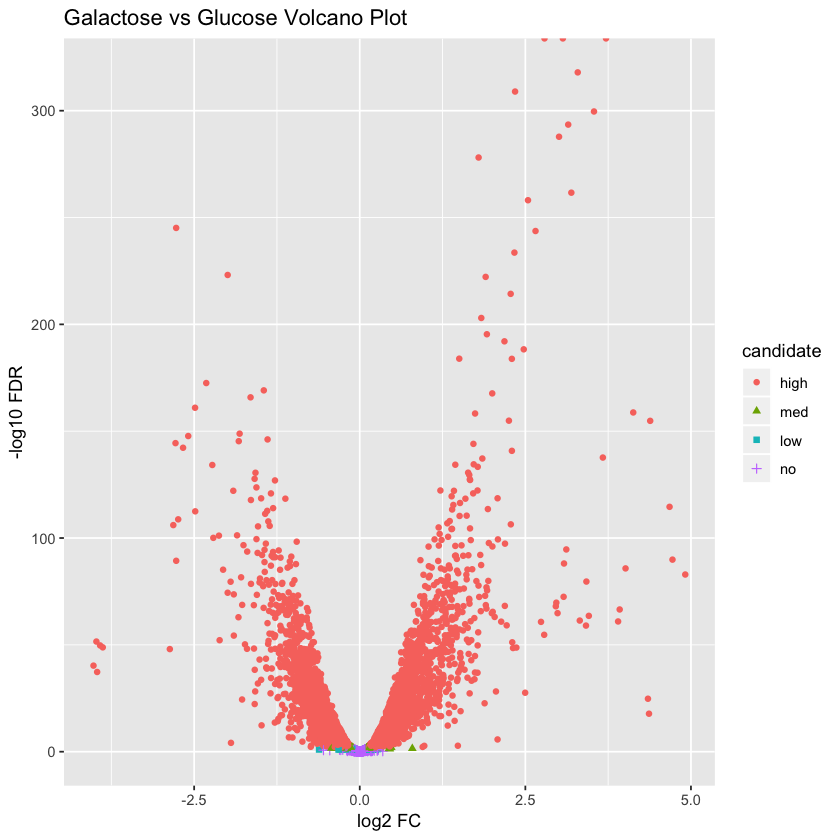

In [22]:
# the ubiquitous volcano plot
volcano_plot(gal_glu, "ave_gal", "ave_glu", "Galactose vs Glucose")

### Most of the proteins are DE candidates

The cluster plot gave us a heads up that there would be a lot of DE candidates. The CVs per condition are so low that even modest fold-changes have very low p-values. There are only 13.6% non-differentially expressed proteins (10% FDR with a BH multiple test correction). There are 80% of the proteins in the **high** category!

### Contrast within conditions to between conditions

Just to double check that the results make sense, we can do a multi-panel scatter plot grid of Gal versus Glu samples.

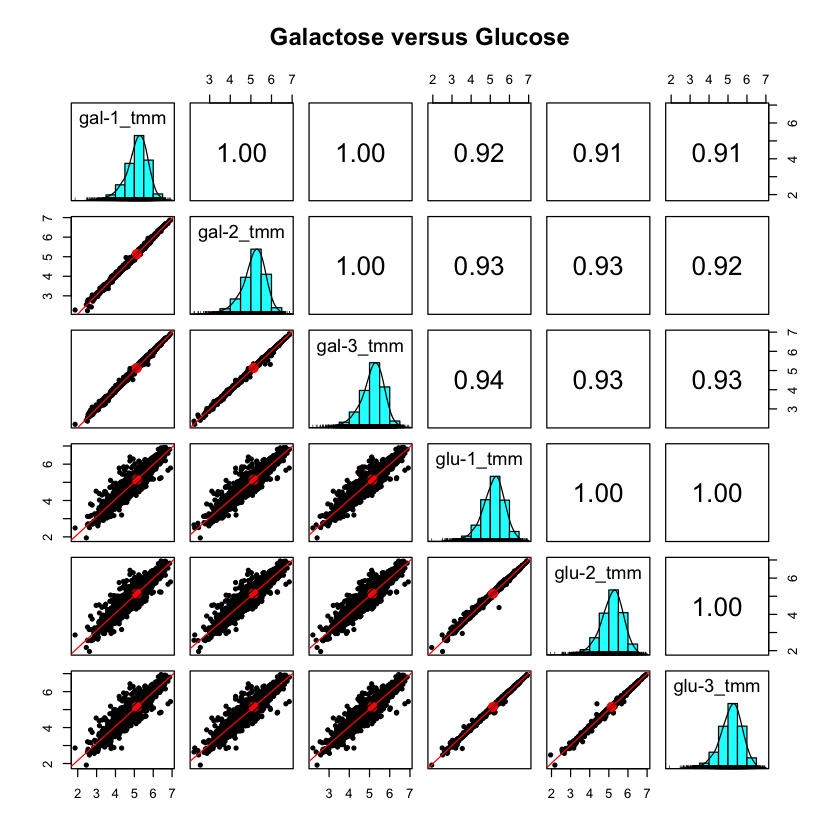

In [23]:
# compare the conditions to each other
pairs.panels(log10(tmt_tmm[c(gal, glu)]), method = "spearman", 
             lm = TRUE, main = "Galactose versus Glucose")

### Within conditions are very tight and between conditions have a lot of scatter

## Galactose versus Raffinose next

In [24]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("gal", "raf"))

# see which proteins have the smallest p-values
topTags(et)$table

# get the results table 
tt <- topTags(et, n = Inf, sort.by = "none")$table
gal_raf <- collect_results(tmt_tmm, tt, gal, "gal", raf, "raf")

genes                 logFC    logCPM   PValue FDR
2241 sp|P40188|RGI2_YEAST  4.680816 7.189261 0      0  
1238 sp|P32907|ATO2_YEAST  4.553552 5.453545 0      0  
1443 sp|P36035|JEN1_YEAST  4.420315 8.195043 0      0  
3381 sp|Q01574|ACS1_YEAST  4.154732 8.370797 0      0  
2855 sp|P50263|SIP18_YEAST 4.127041 9.704249 0      0  
2108 sp|P39932|STL1_YEAST  3.721546 4.037952 0      0  
830  sp|P25613|ADY2_YEAST  3.698972 5.356059 0      0  
448  sp|P15202|CATA_YEAST  3.355131 5.560097 0      0  
2009 sp|P39004|HXT7_YEAST  3.015449 7.024277 0      0  
3289 sp|P53978|EF3B_YEAST  2.897243 8.710529 0      0

### Check the p-value distribution

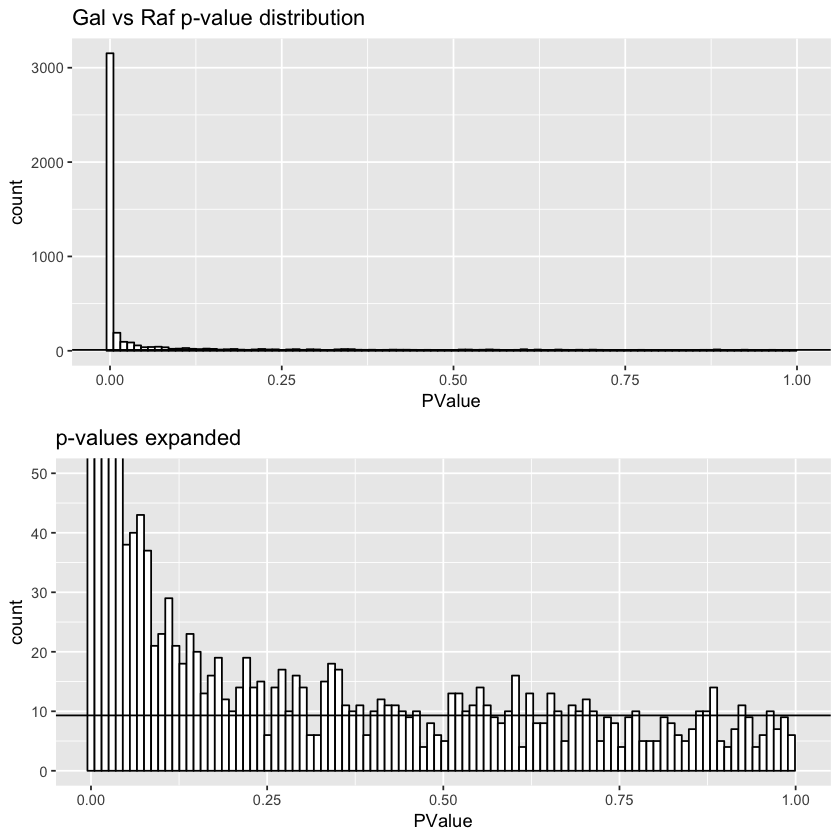

In [25]:
# check the p-value distribution
pvalue_plots(gal_raf, 50, "Gal vs Raf")

### P-value distribution looks okay

### Get candidate numbers and make an MA plot

       raf-gal
Down      1857
NotSig    1008
Up        1863

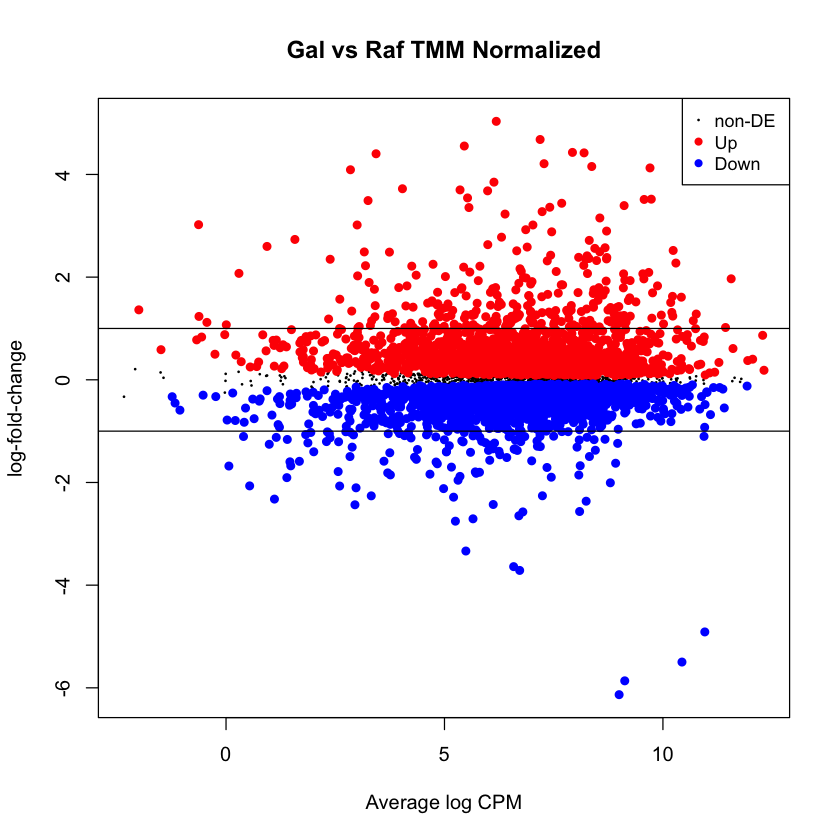

In [26]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))

# use function from limma for MD plot
plotMD(et, main = "Gal vs Raf TMM Normalized", p.value = 0.10)
abline(h = c(-1, 1), col = "black")

### Counts by category and logFC plots

candidate n   
1 high      3199
2 med        337
3 low        184
4 no        1008

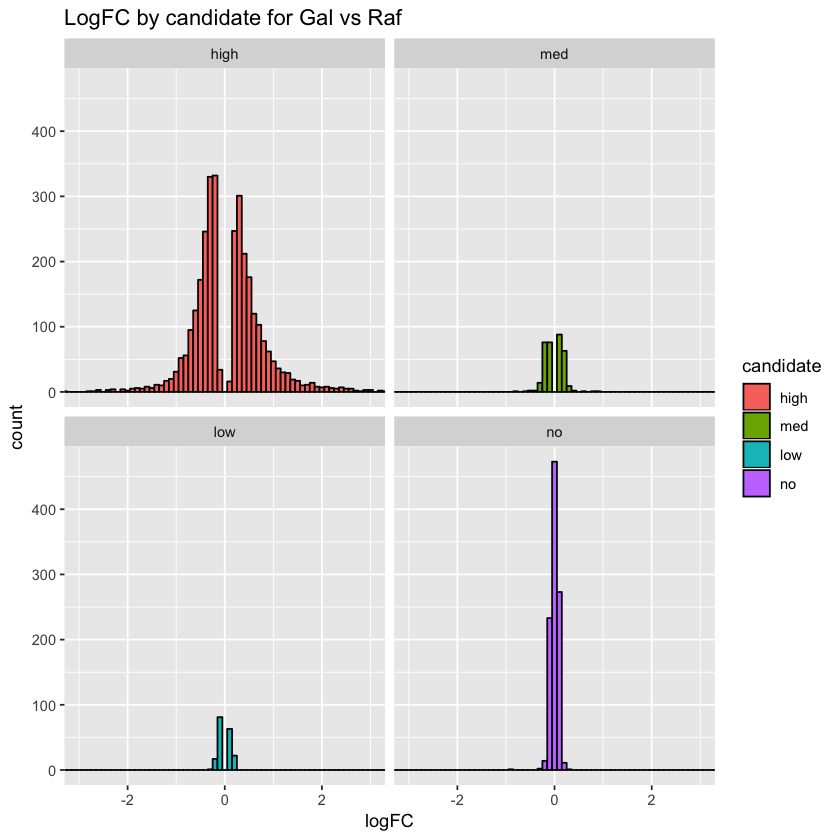

In [27]:
# see how many candidates are in each category
gal_raf %>% count(candidate)

# can also look at log2FC distributions
log2FC_plots(gal_raf, 3, "LogFC by candidate for Gal vs Raf")

### The ggplot MA plots

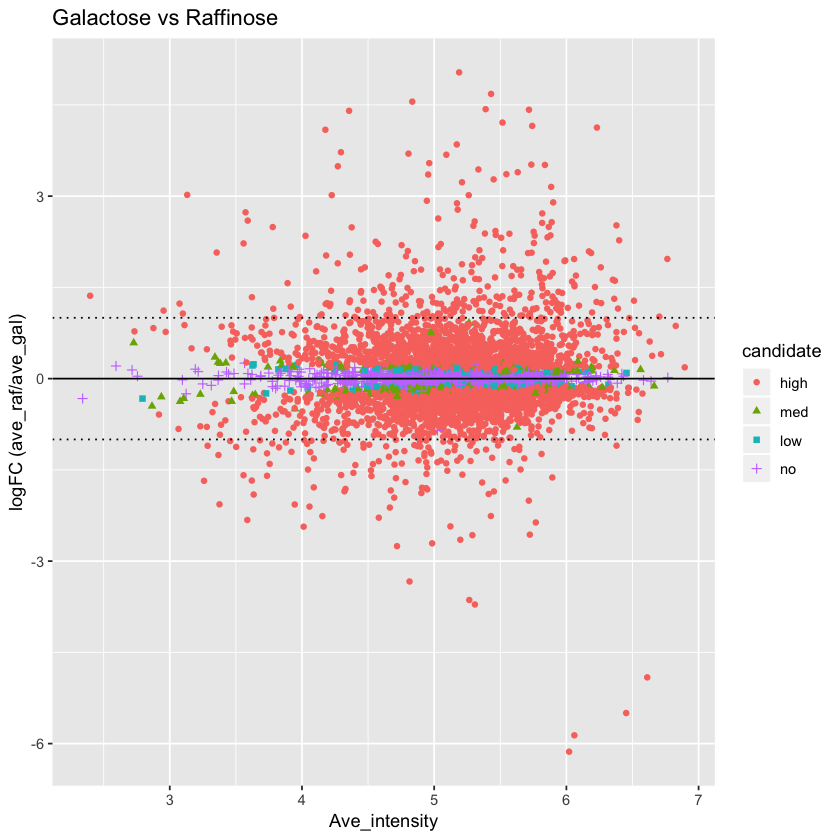

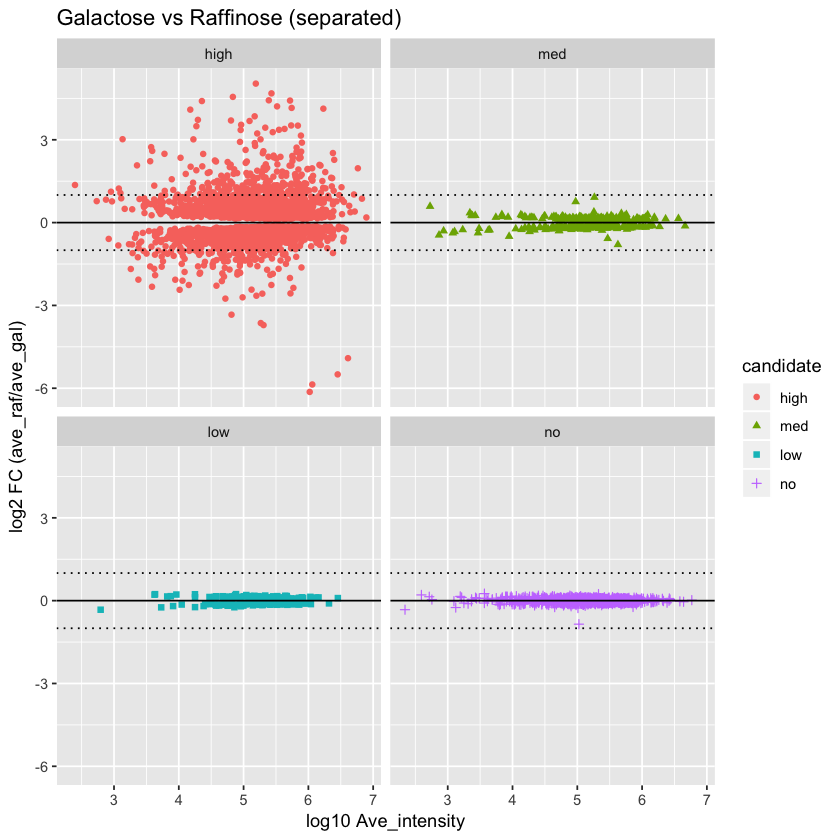

In [28]:
# make the MA plots
MA_plots(gal_raf, "ave_gal", "ave_raf", "Galactose vs Raffinose")

### Scatter plots next

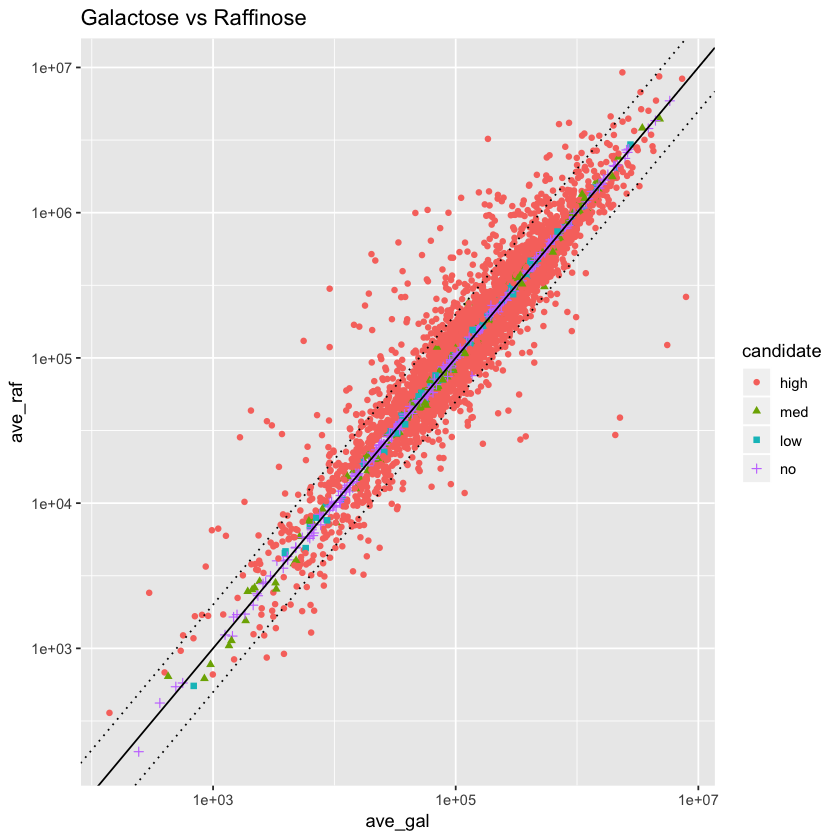

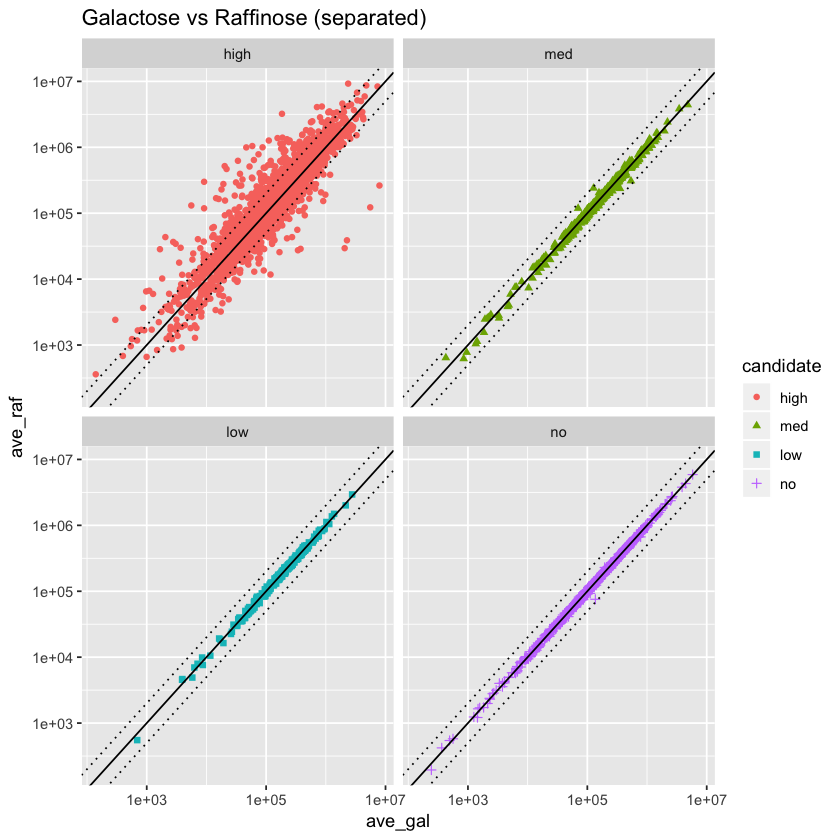

In [29]:
# scatter plots
scatter_plots(gal_raf, "ave_gal", "ave_raf", "Galactose vs Raffinose")

### And the Volcano plot

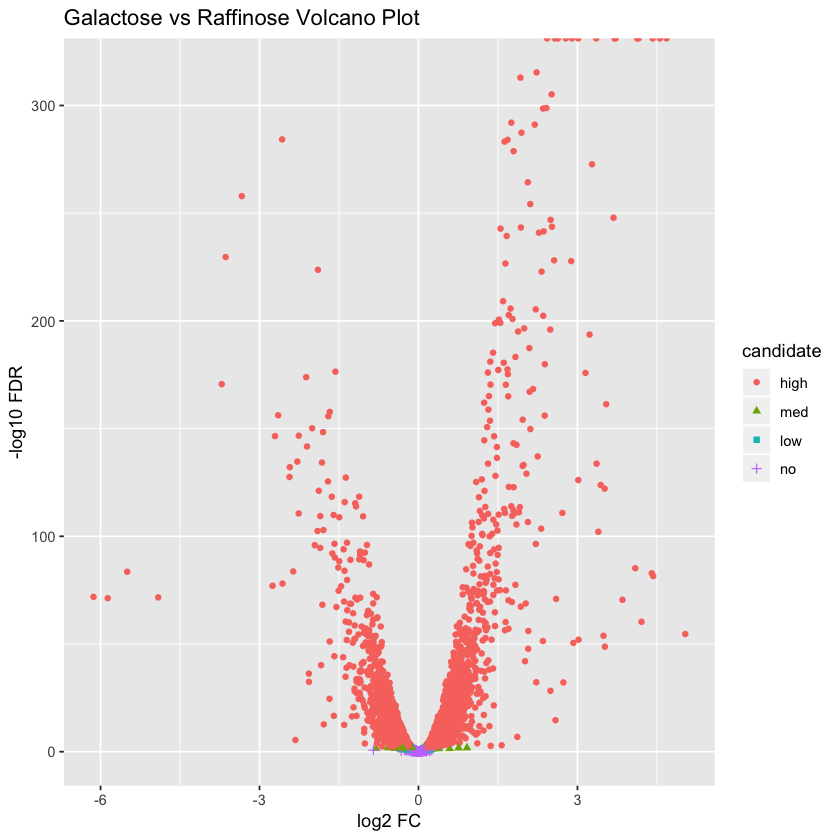

In [30]:
volcano_plot(gal_raf, "ave_gal", "ave_raf", "Galactose vs Raffinose")

### Similar pattern to Gal vs Glu comparison

We had a few more non-differentially expressed proteins in Gal vs Raf than we saw in the Gal vs Glu comparison. We still have an overwhelmingly large number of DE candidates.

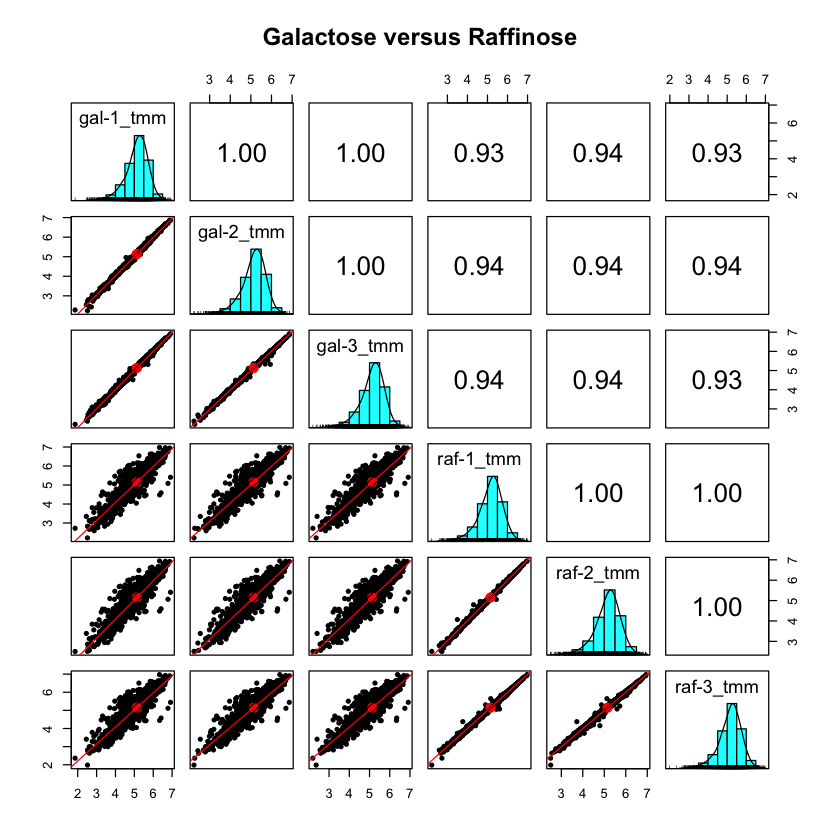

In [31]:
# compare the conditions to each other
pairs.panels(log10(tmt_tmm[c(gal, raf)]), method = "spearman", 
             lm = TRUE, main = "Galactose versus Raffinose")

### Within conditions are very tight and between conditions have a lot of scatter

## Finally, Glucose versus Raffinose

In [32]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("glu", "raf"))

# see which proteins have the smallest p-values
topTags(et)$table

# get the results table 
tt <- topTags(et, n = Inf, sort.by = "none")$table
glu_raf <- collect_results(tmt_tmm, tt, glu, "glu", raf, "raf")

genes                 logFC    logCPM    PValue FDR
2855 sp|P50263|SIP18_YEAST 3.783657  9.704249 0      0  
3944 sp|Q06236|SHH4_YEAST  3.479148  6.757676 0      0  
862  sp|P26263|PDC6_YEAST  3.325771  8.481162 0      0  
3752 sp|Q04487|SHH3_YEAST  3.181202  5.810311 0      0  
680  sp|P22943|HSP12_YEAST 3.140636 10.296588 0      0  
4101 sp|Q07653|HBT1_YEAST  3.109136 10.234560 0      0  
2283 sp|P40355|YJ31_YEAST  3.074446  6.985173 0      0  
2874 sp|P51533|PDR10_YEAST 2.963758  6.653939 0      0  
25   sp|P00175|CYB2_YEAST  2.911474  7.604544 0      0  
4081 sp|Q07500|NDH2_YEAST  2.771289  8.188238 0      0

### Check p-values

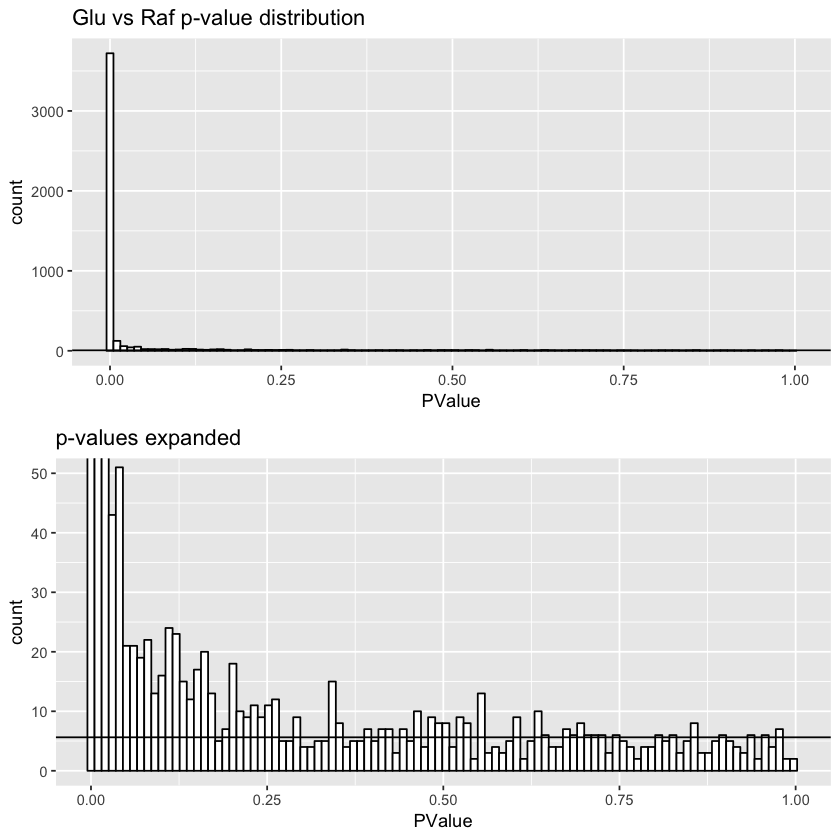

In [33]:
# check the p-value distribution
pvalue_plots(glu_raf, 50, "Glu vs Raf")

### Get candidate counts and make basic MA plot

       raf-glu
Down      2023
NotSig     646
Up        2059

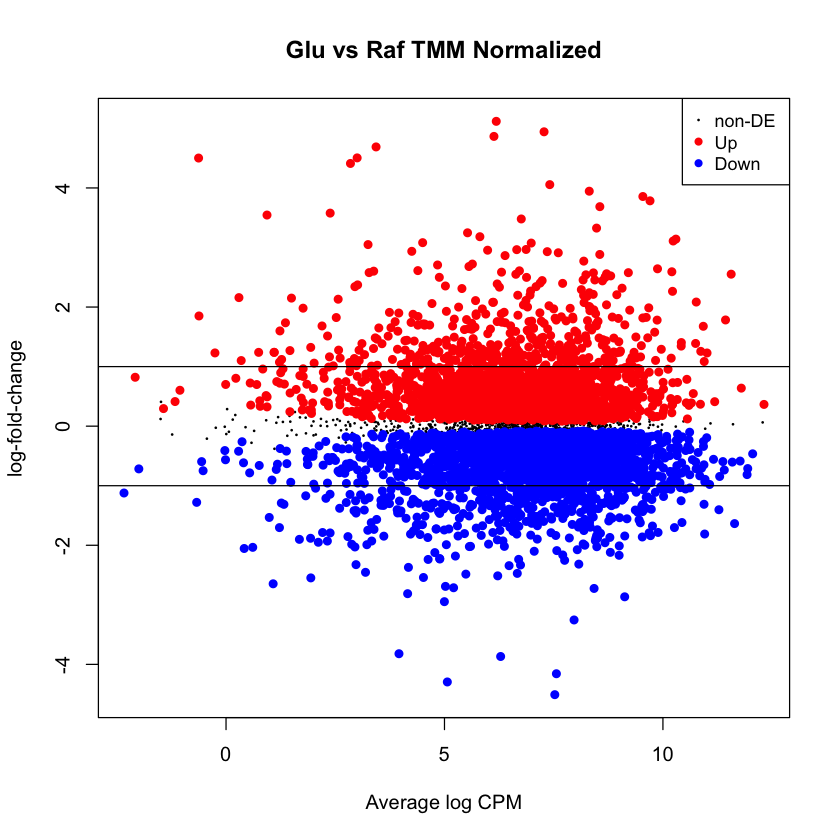

In [34]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))

# use function from limma for MD plot
plotMD(et, main = "Glu vs Raf TMM Normalized", p.value = 0.10)
abline(h = c(-1, 1), col = "black")

### Counts by category and logFC plots

candidate n   
1 high      3774
2 med        206
3 low        102
4 no         646

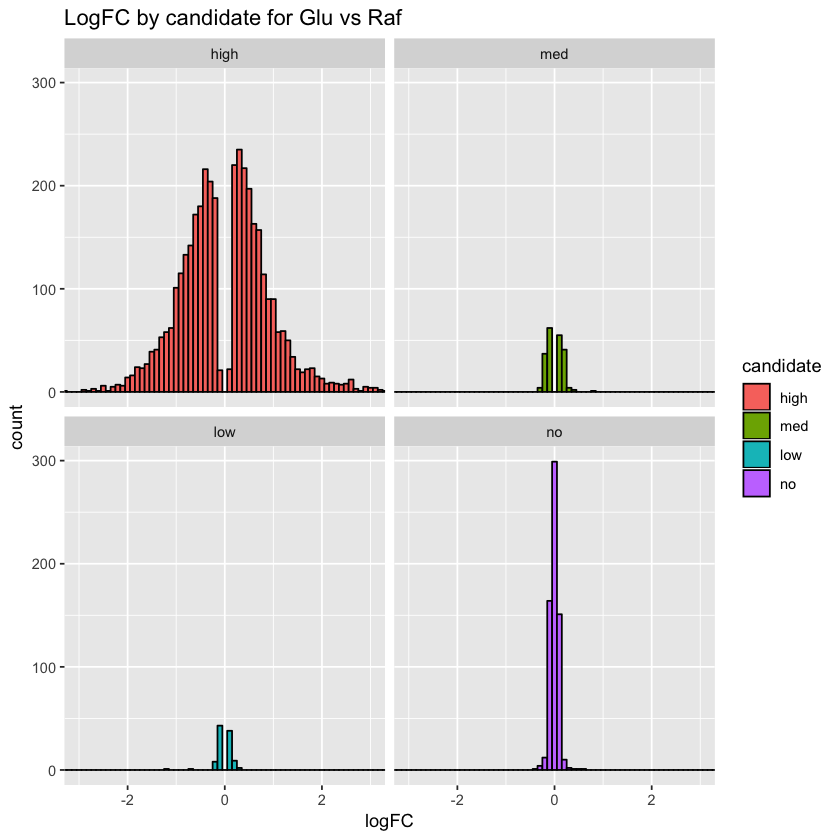

In [35]:
# see how many candidates are in each category
glu_raf %>% count(candidate)

# can also look at log2FC distributions
log2FC_plots(glu_raf, 3, "LogFC by candidate for Glu vs Raf")

### MA plots first

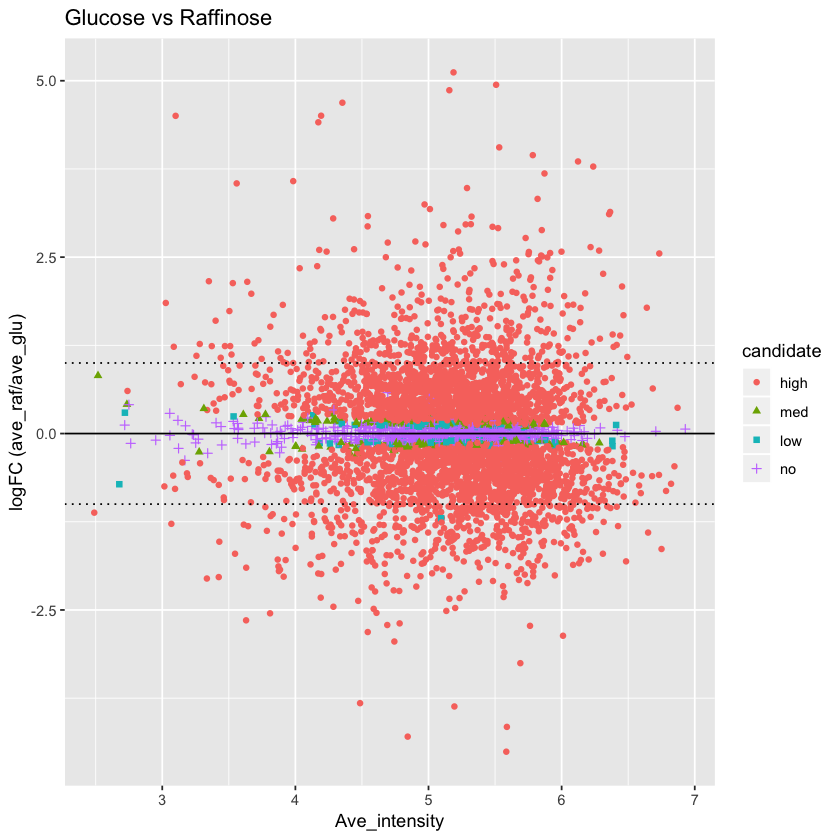

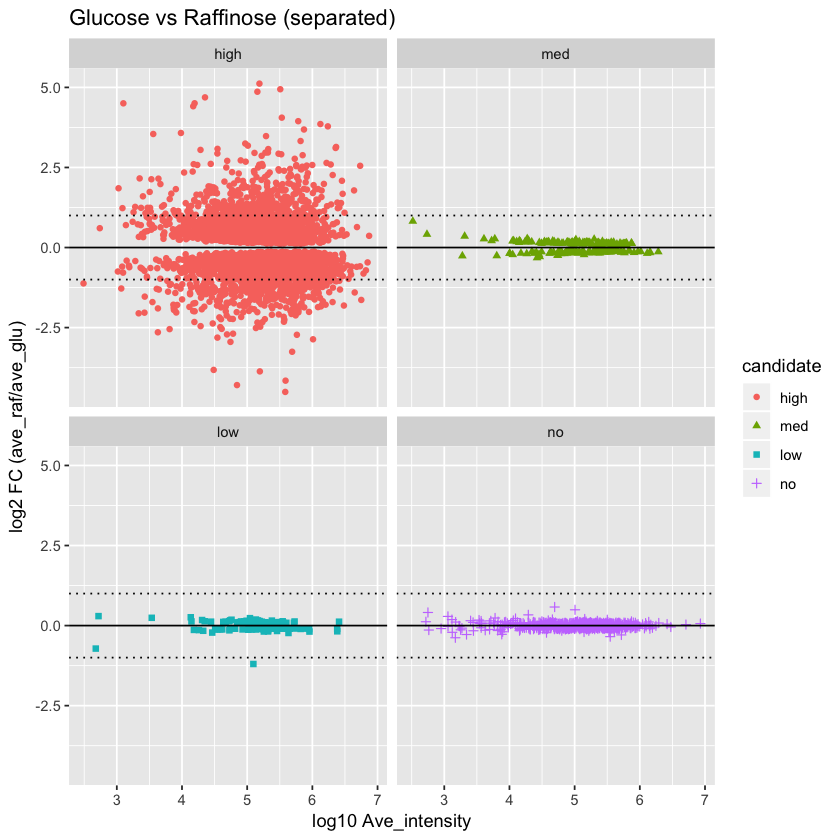

In [36]:
# MA plots for glu vs raf
MA_plots(glu_raf, "ave_glu", "ave_raf", "Glucose vs Raffinose")

### Scatter plots

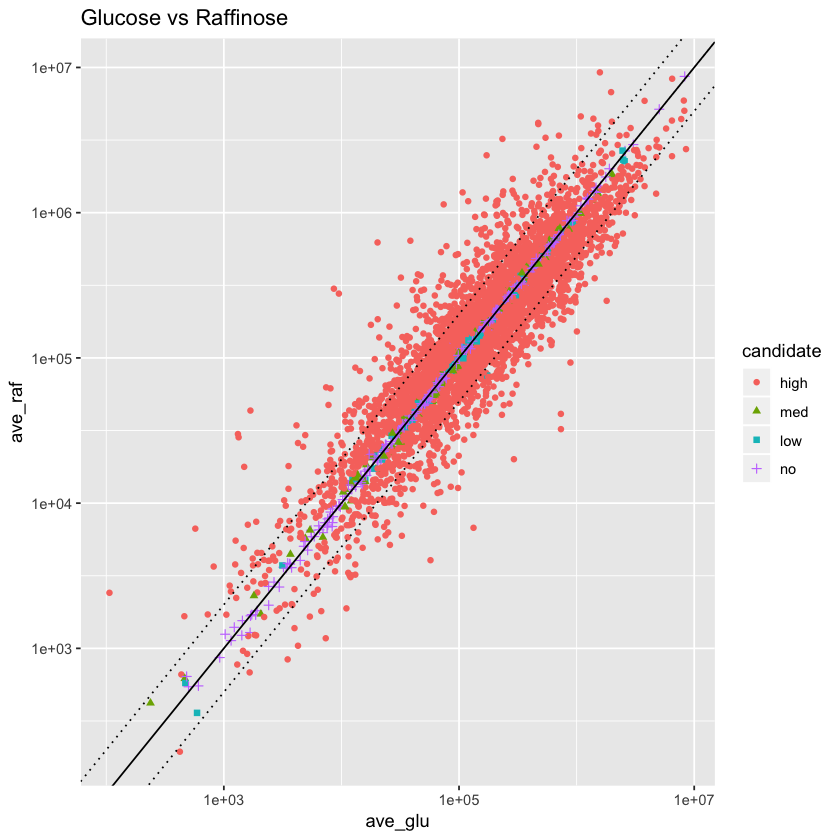

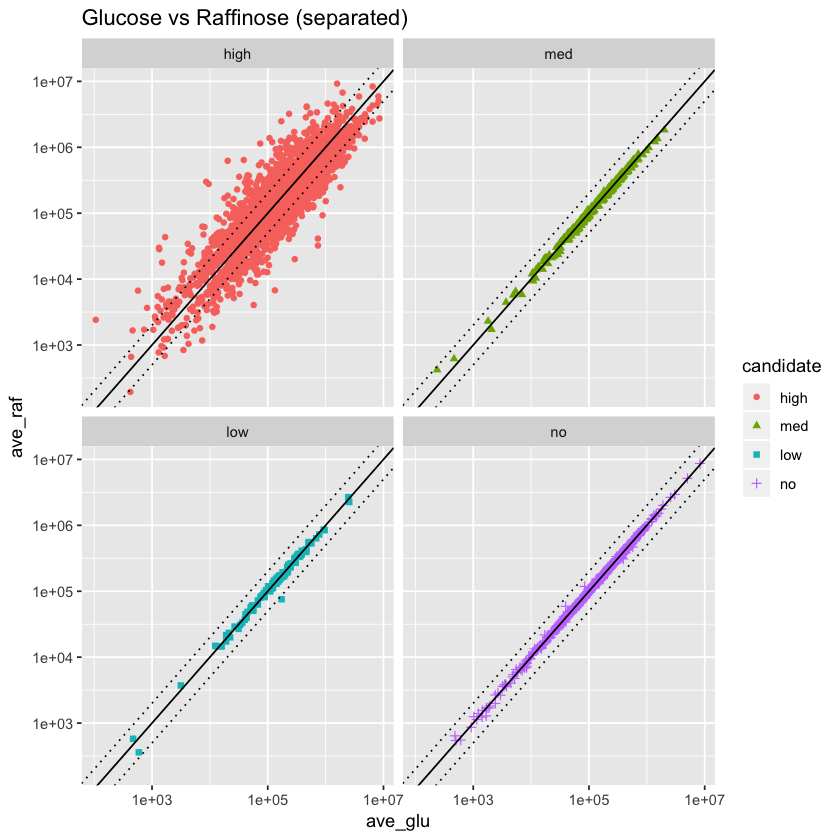

In [37]:
# scatter plots
scatter_plots(glu_raf, "ave_glu", "ave_raf", "Glucose vs Raffinose")

### Volcano plot

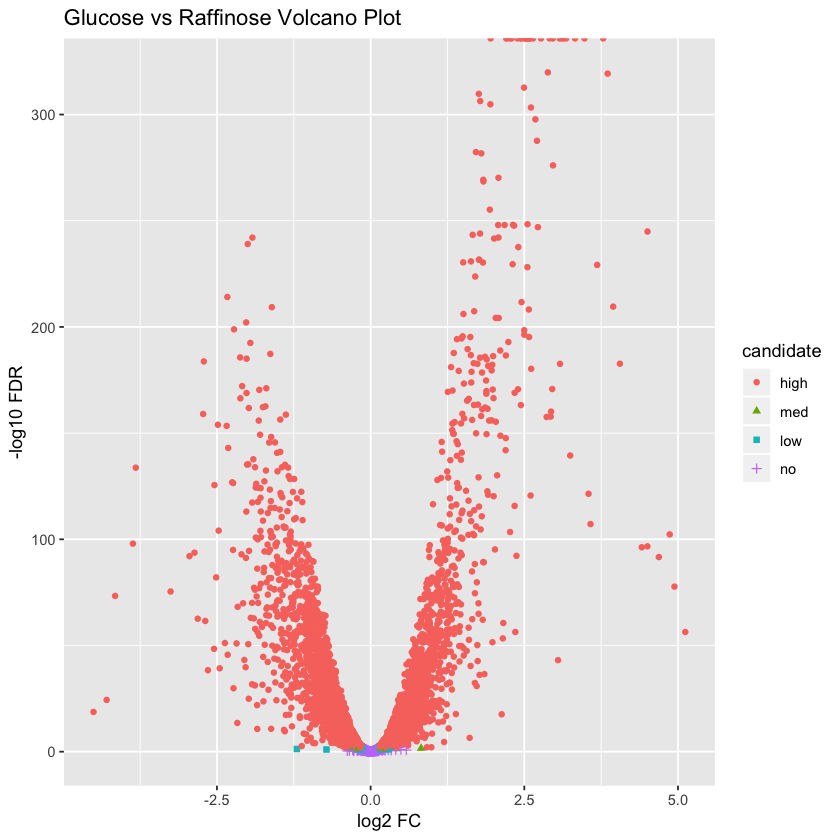

In [38]:
volcano_plot(glu_raf, "ave_glu", "ave_raf", "Glucose vs Raffinose")

### Seeing a similar pattern to the other two comparisons

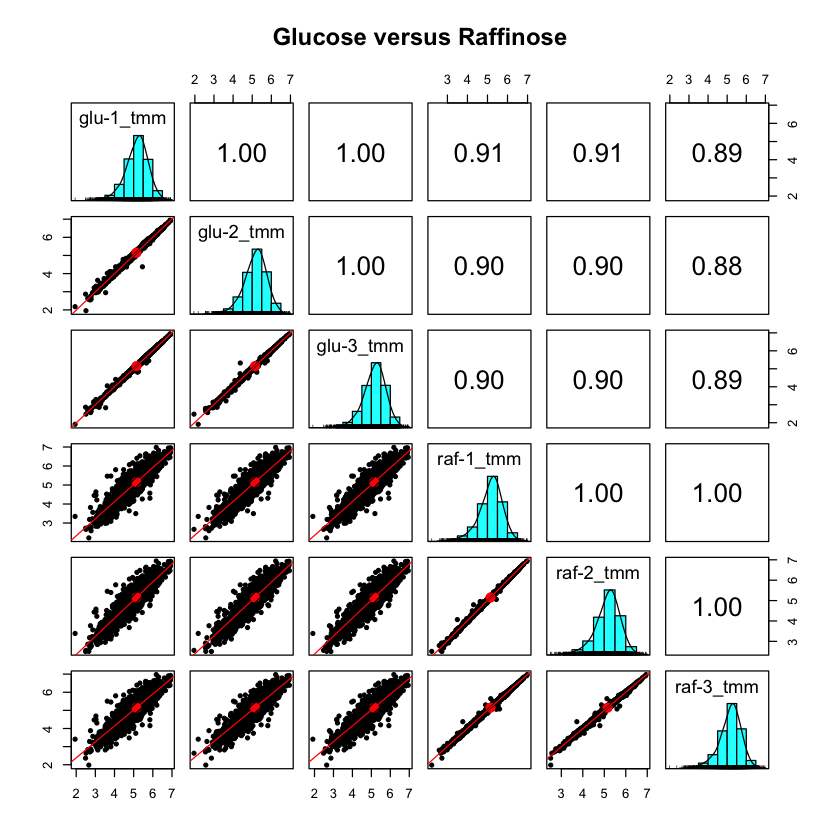

In [39]:
# compare the conditions to each other
pairs.panels(log10(tmt_tmm[c(glu, raf)]), method = "spearman", 
             lm = TRUE, main = "Glucose versus Raffinose")

### Within conditions are very tight and between conditions have a lot of scatter


# Summary

Changing the carbon source seems to have a dramatic effect of the yeast protein expression levels.

In all three comparisons, we had:
- small CV values
- very tight within condition scatter plots
- much broader scatter plots between conditions
- very high numbers of statistically significant DE candidates

The numbers of candidates are around 75% of the proteins with a basic 5% FDR cutoff. Can quantitative proteomics data be **too good**? Does changing the carbon source change the expression levels of every protein in yeast? Or is the reproducibility between biological replicates for yeast in the Gygi lab hands so good that biologically insignificant expression changes are statistically significant changes? The answer probably lies somewhere in the middle. My previous experiences with edgeR testing of TMT data suggests that the modeling is pretty conservative, so I suspect that changing the energy source for yeast is a pretty big perturbation.

This raises the open question of how to proceed when some perturbation causes wholesale protein expression changes and you have a precise method for measuring protein expression. The statistical testing will indicate that practically all proteins are changing. How to rank the candidates for hypotheses and follow up studies is an open problem in modern genomics and now in proteomics.

We will explore what different statistical tests and test options have on the numbers DE results in the next notebook. More advanced features of edgeR allow minimum fold-change criteria to be incorporated into the modeling. Different multiple testing corrections also vary from less conservative to overly conservative and might be important factors.

## Comparison to PAW

|Pipeline|MS2 Scans|Accepted Scans|FDR|ID rate|
|---------|-------|------|-----|-----|
|PAW |744,875|179,146|1.03%|24.1%|
|MaxQuant|746,852|150,613|1%|20.2%|

There are fewer PSMs identified with MaxQuant compared to PAW. There are several likely factors: SEQUEST-like searches are generally more sensitive than Mascot-like searches; a discriminant function or classifier like Percolator improves sensitivity over primary search engine scores; and wider parent ion tolerance searches can better distinguish signal from noise.

Differences at the protein level can be harder to assess. This is especially true when we are essentially identifying the entire yeast proteome. In fact, once you identify in your sample a significant fraction of the proteins in FASTA file, estimating protein FDR using decoy protein matches becomes inaccurate. I kept the default MQ setting of a 1% protein FDR. That may not be a good choice in this case.

Protein inference and identification requirements differ between PAW and MQ. PAW requires two peptides per protein. MaxQuant tries to control FDR at the protein level with a protein ranking function and using decoy protein information. MQ allows single peptide per protein identifications. MQ uses a different protein grouping strategy, too. MQ uses a razor peptide (Occam's razor reference) concept; PAW does homologous family grouping.

If one was curious about more specific comparisons between pipelines, that is mostly impossible. We can see that if we arranged both notebooks (PAW and MQ) side-by-side, that everything is qualitatively nearly identical. Since we have rather different numbers of PSMs, all aggregations levels above PSMs will diverge to various degrees. The relative intensities between channels (the most important feature) will be preserved in either pipeline. The overall magnitudes of the aggregated intensities will not be comparable. 

## Export the results and log the session

We still need to get these results back into our main results spreadsheet. We will also log the R session for our records.

In [40]:
# save the results file to add back to the main spreadsheet
results <- cbind(gal_glu, gal_raf, glu_raf)
write.table(results, "CarbonSources_results.txt", sep = "\t", row.names = FALSE, na = " ")

In [41]:
# log the session information
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.2

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] edgeR_3.24.3    limma_3.38.3    scales_1.0.0    gridExtra_2.3  
 [5] forcats_0.3.0   stringr_1.3.1   dplyr_0.7.8     purrr_0.3.0    
 [9] readr_1.3.1     tidyr_0.8.2     tibble_2.0.1    ggplot2_3.1.0  
[13] tidyverse_1.2.1 psych_1.8.12   

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0       locfit_1.5-9.1   lubridate_1.7.4  lattice_0.20-38 
 [5] assertthat_0.2.0 digest_0.6.18    IRdisplay_0.7.0  R6_2.3.0        
 [9] cellranger_1.1.0 plyr_1.8.4       repr_0.19.1      backports_1.1.